# Lungs Segmentation: EDA

## Import Libraries

In [1]:
# Image Processing Libraries
import cv2
from cv2 import imread,resize
from scipy.ndimage import label, find_objects

# Data Handling Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Visualization Libraries
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import seaborn as sns
from tqdm import tqdm

# File and Operating System Libraries
import os
from glob import glob

# Warnings Management
import warnings
warnings.filterwarnings('ignore')

In [2]:
# utility function
def plot_value_counts(series: pd.Series):
    """
    Plots the value counts of a pandas Series as a bar chart with gradient colors based on value.

    Parameters:
    series (pd.Series): The pandas Series to plot.

    Returns:
    None
    """
    if not isinstance(series, pd.Series):
        raise ValueError("Input must be a pandas Series.")

    # Compute value counts
    value_counts = series.value_counts()

    # Normalize the counts for the gradient
    norm = Normalize(vmin=value_counts.min(), vmax=value_counts.max())
    cmap = plt.cm.viridis  # Choose a colormap

    # Create the colors based on normalized values
    colors = cmap(norm(value_counts.values))

    # Plot the bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(value_counts.index.astype(str), value_counts.values, color=colors)

    # Add a colorbar
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Count', rotation=270, labelpad=15)

    # Set title (use series name if available)
    title = series.name if series.name else "Value Counts"
    ax.set_title(title, fontsize=14)

    # Add labels and formatting
    ax.set_xlabel("Values", fontsize=12)
    ax.set_ylabel("Counts", fontsize=12)
    ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

## Get Data

In [3]:
!kaggle datasets download iamtapendu/chest-x-ray-lungs-segmentation

Dataset URL: https://www.kaggle.com/datasets/iamtapendu/chest-x-ray-lungs-segmentation
License(s): apache-2.0
100% 3.59G/3.59G [00:48<00:00, 138MB/s]
100% 3.59G/3.59G [00:48<00:00, 80.2MB/s]


In [4]:
!unzip chest-x-ray-lungs-segmentation.zip

Archive:  chest-x-ray-lungs-segmentation.zip
  inflating: Chest-X-Ray/Chest-X-Ray/image/1000.png  
  inflating: Chest-X-Ray/Chest-X-Ray/image/1001.png  
  inflating: Chest-X-Ray/Chest-X-Ray/image/1002.png  
  inflating: Chest-X-Ray/Chest-X-Ray/image/1003.png  
  inflating: Chest-X-Ray/Chest-X-Ray/image/1004.png  
  inflating: Chest-X-Ray/Chest-X-Ray/image/1005.png  
  inflating: Chest-X-Ray/Chest-X-Ray/image/1006.png  
  inflating: Chest-X-Ray/Chest-X-Ray/image/1007.png  
  inflating: Chest-X-Ray/Chest-X-Ray/image/1008.png  
  inflating: Chest-X-Ray/Chest-X-Ray/image/1009.png  
  inflating: Chest-X-Ray/Chest-X-Ray/image/1010.png  
  inflating: Chest-X-Ray/Chest-X-Ray/image/1011.png  
  inflating: Chest-X-Ray/Chest-X-Ray/image/1012.png  
  inflating: Chest-X-Ray/Chest-X-Ray/image/1013.png  
  inflating: Chest-X-Ray/Chest-X-Ray/image/1014.png  
  inflating: Chest-X-Ray/Chest-X-Ray/image/1015.png  
  inflating: Chest-X-Ray/Chest-X-Ray/image/1016.png  
  inflating: Chest-X-Ray/Chest-X-Ray/

In [5]:
# PATHS
IMG_PATH = 'Chest-X-Ray/Chest-X-Ray/image/'
MSK_PATH = 'Chest-X-Ray/Chest-X-Ray/mask/'

## Metadata

In [6]:
metadata = pd.read_csv('MetaData.csv')
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       704 non-null    int64 
 1   gender   704 non-null    object
 2   age      704 non-null    object
 3   county   704 non-null    object
 4   ptb      704 non-null    int64 
 5   remarks  699 non-null    object
dtypes: int64(2), object(4)
memory usage: 33.1+ KB


In [7]:
metadata.sample(5)

,id,gender,age,county,ptb,remarks
625,1625,F,020,Montgomery,0,normal
471,1471,male,63,Shenxhen,1,"Right pneumothorax, Right upper PTB, bilateral..."
273,1273,male,31,Shenxhen,0,normal
634,1634,M,024,Montgomery,1,RUL infiltrate consistent with TB
254,1254,Male,27,Shenxhen,1,Left secondary PTB in the upper and middle fie...


In [8]:
gender_mapping = {
    'm': 'male', 'Male,': 'male', 'male35yrs': 'male', 'male,':'male',
    'f': 'female', 'femal': 'female', 'female24yrs':'female','o':'female','female,':'female'
}
metadata.gender = metadata.gender.str.lower()
metadata.gender.replace(gender_mapping,inplace=True)

In [9]:
metadata['gender'].value_counts()

,count
gender,
male,441
female,263


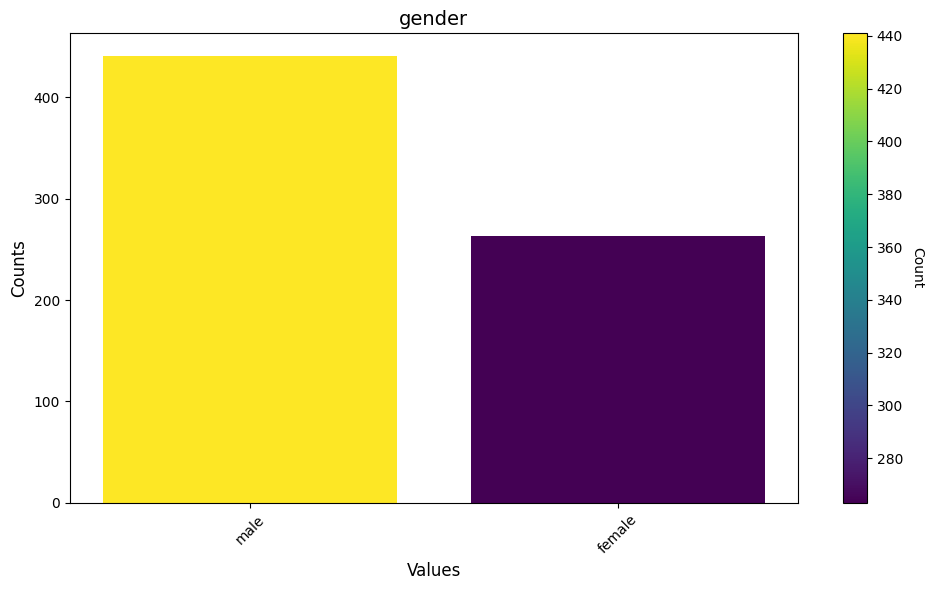

In [10]:
plot_value_counts(metadata['gender'])

In [11]:
metadata.age = (metadata.age
                .replace({'16month':'1','39yr':'39','1yr':'1','male35':'35','female24':'24'})
                .astype(int))

<Axes: xlabel='age', ylabel='Count'>

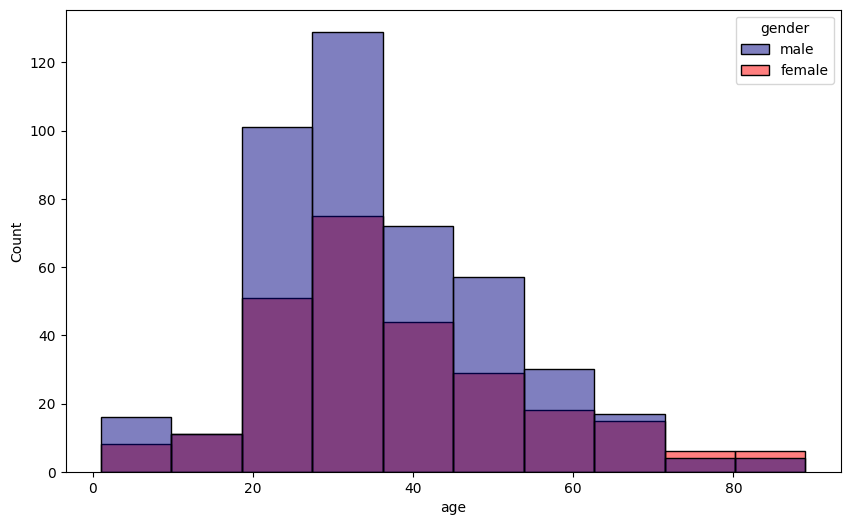

In [12]:
# Plot the bar chart
# Plot the chart
custom_palette = ['navy','red']
plt.figure(figsize=(10, 6))
sns.histplot(data=metadata, x="age", hue="gender", palette=custom_palette, bins=10, kde=False)

<Figure size 1400x800 with 0 Axes>

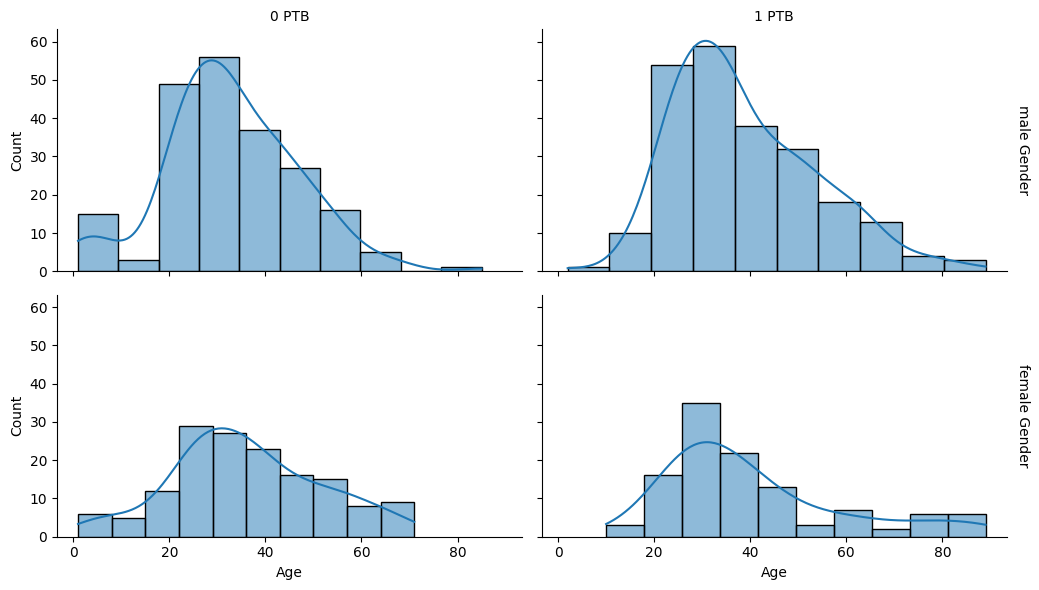

In [13]:
# FacetGrid of Age by Gender and PTB
plt.figure(figsize=(14,8))
g = sns.FacetGrid(metadata, col='ptb', row='gender', margin_titles=True,aspect=1.75)
g.map(sns.histplot, 'age', bins=10, kde=True)

# Adding titles and labels
g.set_axis_labels('Age', 'Count')
g.set_titles(col_template="{col_name} PTB", row_template="{row_name} Gender")

# Show the plot
plt.show()

## Lung Masks

In [14]:
def get_colored_mask(image, mask_image,color = [255,20,255]):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    mask_coord = np.where(mask!=[0,0,0])
    mask[mask_coord[0],mask_coord[1],:]= color
    ret = cv2.addWeighted(image, 0.6, mask, 0.4, 0)
    return ret

In [15]:
filenames = glob(f'{IMG_PATH}/*.png')[:3]
filenames

['Chest-X-Ray/Chest-X-Ray/image/1703.png',
 'Chest-X-Ray/Chest-X-Ray/image/1358.png',
 'Chest-X-Ray/Chest-X-Ray/image/1211.png']

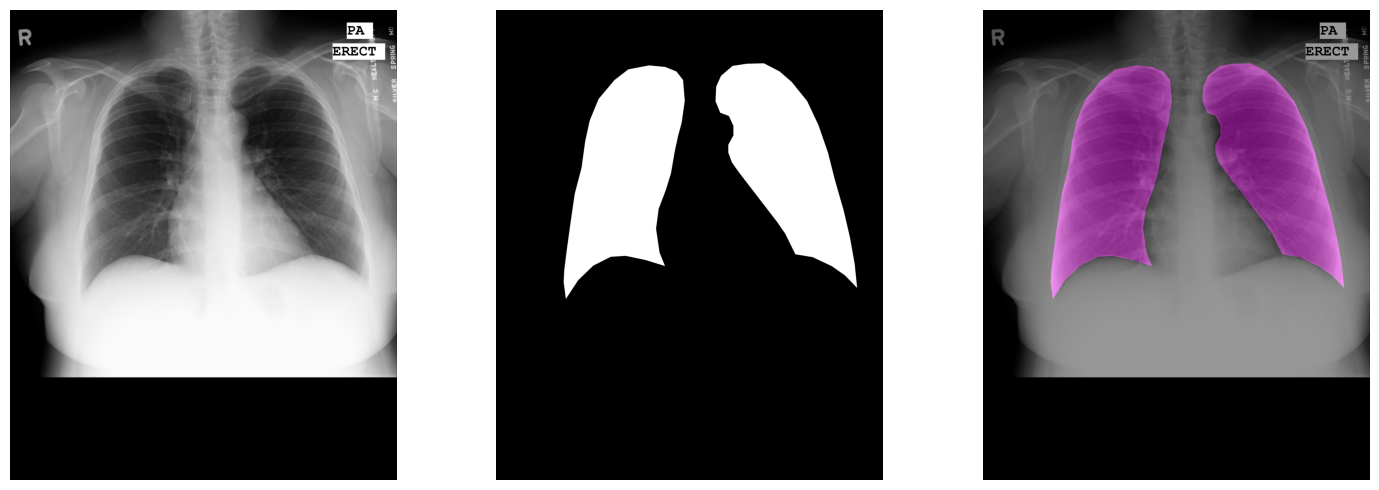

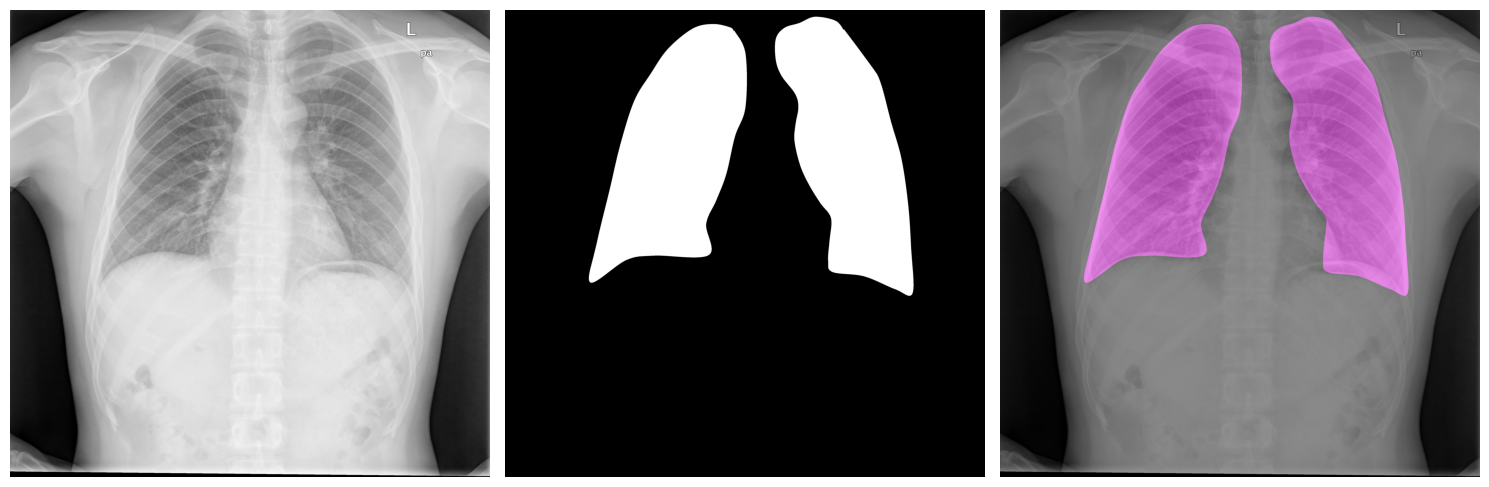

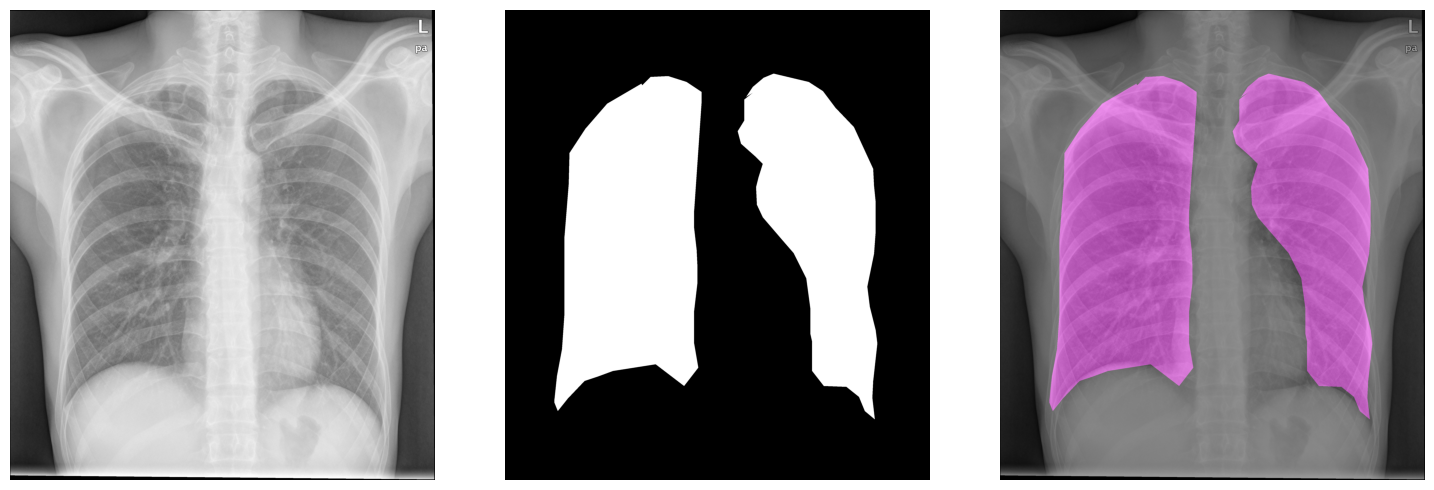

In [16]:
for file in filenames:
    img = imread(file)
    msk = imread(file.replace('image/', 'mask/'))

    plt.figure(figsize=(15,5))

    plt.subplot(131)
    plt.imshow(img)
    plt.yticks([])
    plt.xticks([])
    plt.box(False)

    plt.subplot(132)
    plt.imshow(msk,cmap='binary_r')
    plt.yticks([])
    plt.xticks([])
    plt.box(False)

    plt.subplot(133)
    plt.imshow(get_colored_mask(img,msk))
    plt.yticks([])
    plt.xticks([])
    plt.box(False)

    plt.tight_layout()
    plt.show()

In [ ]:
msk.ndim

3

# Modeling

## Import DL Libraries
Import libraries needed for training

In [17]:
# TensorFlow and Keras Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint

# Image Processing Libraries
import cv2
from cv2 import imread,resize
from scipy.ndimage import label, find_objects

# Data Handling Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [18]:
# GPU Configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data Generator

In [19]:
class DataGenerator(keras.utils.PyDataset):
    def __init__(self, img_files, mask_files, batch_size=32, size=(512, 512), seed=1, shuffle=True, **kwargs):
        """
        Custom data generator for segmentation tasks.

        Args:
        - img_dir: Directory containing the input images
        - mask_dir: Directory containing the corresponding masks
        - batch_size: Number of samples per batch
        - size: The target size for resizing the images and masks
        - seed: Random seed for reproducibility
        - shuffle: Whether to shuffle the dataset after each epoch
        """
        super().__init__(**kwargs)

        # List image and mask files
        self.img_filenames = img_files
        self.mask_filenames = mask_files

        self.batch_size = batch_size
        self.size = size
        self.seed = seed
        self.shuffle = shuffle

        # Ensure the number of images matches the number of masks
        assert len(self.img_filenames) == len(self.mask_filenames), \
            "The number of images and masks must be the same"

        self.indexes = np.arange(len(self.img_filenames))  # Indices for shuffling

        # If shuffle is enabled, shuffle the indices after each epoch
        if self.shuffle:
            self.on_epoch_end()

    def __len__(self):
        """
        Returns the number of batches per epoch.
        """
        return int(np.floor(len(self.img_filenames) / self.batch_size))

    def __getitem__(self, index):
        """
        Generates a batch of data (images and corresponding masks).

        Args:
        - index: The index of the batch.

        Returns:
        - A batch of images and masks
        """
        # Get batch indices
        batch_indices = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        # Initialize empty arrays for the batch
        images = []
        masks = []

        for i, idx in enumerate(batch_indices):
            # Load and preprocess image
            img = imread(IMG_PATH+self.img_filenames[idx],0)  # Read image
            img = resize(img, self.size)  # Resize to target size
            img = img / 255.0  # Normalize to [0, 1]

            # Load and preprocess mask
            mask = imread(MSK_PATH+self.mask_filenames[idx],0)  # Read mask
            mask = resize(mask, self.size)  # Resize to target size
            # mask = cv2.dilate(mask, np.ones((15, 15), np.uint8), iterations=1)
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
            mask = mask / 255.0  # Normalize to [0, 1]
            mask[mask > 0.5] = 1  # Binary mask

            # Add image and mask to the batch arrays
            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        """
        Shuffle the dataset after each epoch.
        """
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [20]:
img_files, msk_files = sorted(os.listdir(IMG_PATH)), sorted(os.listdir(MSK_PATH))

train_img_files, val_img_files, train_msk_files, val_msk_files = train_test_split(img_files,msk_files,test_size=0.3,random_state=1)

In [21]:
train_data = DataGenerator(
    img_files=train_img_files,
    mask_files=train_msk_files,
    batch_size=8,
    size=(512, 512),
    workers=4,
    use_multiprocessing=True
)

val_data = DataGenerator(
    img_files=val_img_files,
    mask_files=val_msk_files,
    batch_size=8,
    size=(512, 512),
    workers=4,
    use_multiprocessing=True
)

## Model

In [22]:
def unet(input_shape, num_classes):
    # Input layer for the model
    inputs = layers.Input(shape=input_shape)

    # Contracting Path (Encoder)
    # First block with 64 filters
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)  # Add Batch Normalization
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)  # Add Batch Normalization
    pool1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv1)  # Downsample

    # Second block with 128 filters
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.BatchNormalization()(conv2)  # Add Batch Normalization
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)  # Add Batch Normalization
    pool2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv2)  # Downsample

    # Third block with 256 filters
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)  # Add Batch Normalization
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)  # Add Batch Normalization
    pool3 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv3)  # Downsample

    # Bottleneck layer with 512 filters
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.BatchNormalization()(conv4)  # Add Batch Normalization
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)  # Add Batch Normalization

    # Expansive Path (Decoder)
    # First upsampling block
    up6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4)  # Upsample
    merge6 = layers.concatenate([up6, conv3])  # Concatenate with the corresponding encoder block
    conv6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = layers.BatchNormalization()(conv6)  # Add Batch Normalization
    conv6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = layers.BatchNormalization()(conv6)  # Add Batch Normalization

    # Second upsampling block
    up7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)  # Upsample
    merge7 = layers.concatenate([up7, conv2])  # Concatenate with the corresponding encoder block
    conv7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = layers.BatchNormalization()(conv7)  # Add Batch Normalization
    conv7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = layers.BatchNormalization()(conv7)  # Add Batch Normalization

    # Third upsampling block
    up8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)  # Upsample
    merge8 = layers.concatenate([up8, conv1])  # Concatenate with the corresponding encoder block
    conv8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = layers.BatchNormalization()(conv8)  # Add Batch Normalization
    conv8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = layers.BatchNormalization()(conv8)  # Add Batch Normalization

    # Output layer for segmentation
    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(conv8)

    # Create the model
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model  # Return the model


In [24]:
# Instantiate the model
input_shape = (512, 512, 1)  # Define the input shape for grayscale images
model = unet(input_shape, 1)  # Create U-Net model for binary segmentation

# Print the model summary
# model.summary()  # Display model architecture

## Loss & Metric Function

In [25]:
# Jaccard Index Metric
def jaccard_index(y_true, y_pred, smooth=100):
    """Calculates the Jaccard index (IoU), useful for evaluating the model's performance."""
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])  # Flatten and cast ground truth
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])  # Flatten and cast predictions
    intersection = tf.reduce_sum(y_true_f * y_pred_f)  # Compute intersection
    total = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection  # Total pixels
    return (intersection + smooth) / (total + smooth)


def dice_coefficient(y_true, y_pred, smooth=1):
    # Flatten and cast true and predicted masks to float32
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])  # Flatten and cast y_true to float32
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])  # Flatten and cast y_pred to float32

    # Calculate the intersection between the true and predicted masks
    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    # Calculate the Dice coefficient using the formula
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


# Using the metrics in model compilation
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',dice_coefficient,jaccard_index])

## Train The Model

In [ ]:
## ModelCheckpoint: Save the model with the best validation loss during training
checkpoint = ModelCheckpoint(
    'best_model.keras',            # Path to save the model
    monitor='val_dice_coefficient',         # Metric to monitor
    verbose=1,                  # Print messages when saving the model
    save_best_only=True,        # Save only the best model (with highest metric)
    mode='max',                 # 'max' means the model with the highest metric score will be saved
    save_weights_only=False,     # Save the entire model (not just weights)
)

# Fit the model with multi-processing enabled
history = model.fit(
    train_data,                  # The training data generator or dataset
    validation_data=val_data,  # Validation data ratio
    epochs=128,              # Number of epochs
    callbacks=[checkpoint],# Callbacks for checkpoint and early stopping
)

Epoch 1/128
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8172 - dice_coefficient: 0.6160 - jaccard_index: 0.4552 - loss: 0.4382
Epoch 1: val_dice_coefficient improved from -inf to 0.26408, saving model to best_model.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 299s 3s/step - accuracy: 0.8184 - dice_coefficient: 0.6175 - jaccard_index: 0.4568 - loss: 0.4359 - val_accuracy: 0.3604 - val_dice_coefficient: 0.2641 - val_jaccard_index: 0.1526 - val_loss: 5.8256
Epoch 2/128
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9415 - dice_coefficient: 0.8036 - jaccard_index: 0.6735 - loss: 0.1740
Epoch 2: val_dice_coefficient did not improve from 0.26408
61/61 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.9416 - dice_coefficient: 0.8039 - jaccard_index: 0.6740 - loss: 0.1737 - val_accuracy: 0.7509 - val_dice_coefficient: 0.0089 - val_jaccard_index: 0.0047 - val_loss: 1.3673
Epoch 3/128
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9640 - dice_coefficient: 0.8802 - jaccard_index: 0.7868 - los